importing columns:

catboost is used as ml model
pandas and numpy used for data manipulation

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn import metrics
from catboost import CatBoostClassifier, Pool

Reading and cleaning data:

train_data and test_data is read
some cells are removed as they were either empty or does not have enough to correlation

In [3]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

remove_cells = ['id', 's54', 's55', 's56', 's57', 's59']

train_data.drop(remove_cells, inplace=True, axis=1)
test_id = test_data['id']
test_data.drop(remove_cells, inplace=True, axis=1)

In [4]:
y = train_data['label']
X = train_data.drop('label', axis = 1)
X.columns

Index(['gender', 's11', 's12', 's13', 's16', 's17', 's18', 's48', 's52', 's53',
       's58', 's69', 's70', 's71', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7',
       'n8', 'n9', 'n10', 'n11', 'n12', 'n13', 'n14', 'n15'],
      dtype='object')

Training and testing model:
cat features are the columns used for categorization
k fold testing is used
catboost turns out to be best model

Auc:  0.8680617231712529
Auc:  0.8733240331705803
Auc:  0.8732548390214735


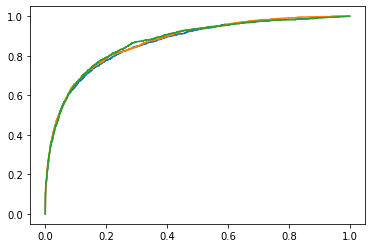

In [5]:
cat_features = ['gender', 's11', 's12', 's13', 's16', 's17', 's18', 's48', 's52', 's53',
    's58', 's69', 's70', 's71']

skf = StratifiedKFold(n_splits=3)

for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    Y_train, Y_test = y[train_idx], y[test_idx]

    pool_train = Pool(X_train, Y_train, cat_features=cat_features)
    pool_test = Pool(X_test, cat_features=cat_features)

    model = CatBoostClassifier(eval_metric='AUC')
    model.fit(pool_train, verbose=0)

    probs = model.predict_proba(pool_test)
    preds = probs[:,1]
    fpr, tpr, thr = metrics.roc_curve(Y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    print('Auc: ', roc_auc)

Auc:  0.8841852639036485


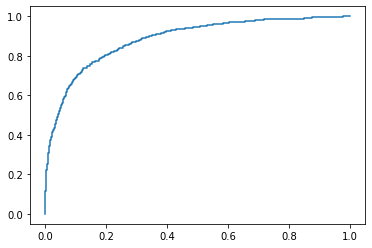

In [11]:
def onefold():
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=.2, random_state=1927)
    
    pool_train = Pool(X_train, Y_train, cat_features=cat_features)
    pool_test = Pool(X_test, cat_features=cat_features)

    model = CatBoostClassifier(eval_metric='AUC')
    model.fit(pool_train, verbose=0)

    return model

    
mod = onefold()

Auc:  0.7725231213659371


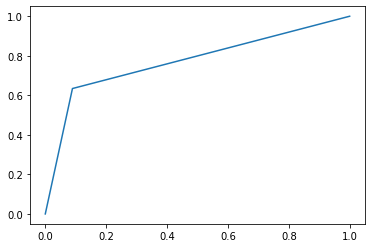

In [21]:
probs = model.predict_proba(pool_test)
preds = probs[:,1]
preds = preds > .3
fpr, tpr, thr = metrics.roc_curve(Y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print('Auc: ', roc_auc)
plt.plot(fpr, tpr)

Training on full data:
Model is trained on full data

In [22]:
pool_train = Pool(X, y, cat_features=cat_features)
pool_eval = Pool(test_data, cat_features=cat_features)

model = CatBoostClassifier(eval_metric='AUC')
model.fit(pool_train, verbose=200)

Learning rate set to 0.042953
0:	total: 94.6ms	remaining: 1m 34s
200:	total: 16.4s	remaining: 1m 5s
400:	total: 41.1s	remaining: 1m 1s
600:	total: 56.8s	remaining: 37.7s
800:	total: 1m 16s	remaining: 19.1s
999:	total: 1m 35s	remaining: 0us


prediction and submission

In [28]:
probs = model.predict_proba(pool_eval)
preds = probs[:, 1]
preds = (preds > .8).astype("int")
submit_df = pd.DataFrame(data={'id' : test_id, 'label': preds})
submit_df.to_csv('Submissiion_QWERTY_41X_bbb121.csv', index=False)

In [29]:
sum(preds)

10481